# Label Propagation 
Reproduced the results in [this](http://mlg.eng.cam.ac.uk/zoubin/papers/CMU-CALD-02-107.pdf) paper.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random 
import pandas as pd
from skimage.measure import block_reduce
from scipy.special import entr
import matplotlib as mpl

In [2]:
PALETTE = ['r', 'b', 'g', 'k']

In [3]:
def plot_digits(instances, images_per_row=10, size=28,**options):
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")



def get_hash(Y):
    """
    Get unique number for input
    one hot vector
    """
    hashes = []
    
    for i in range(len(Y)):
        index = np.argmax(Y[i])
        if Y[i][index] == 0:
            index = len(PALETTE) - 1
        hashes.append(index)
    return hashes

def get_classes(Y):
    hashes = get_hash(Y)
    return [PALETTE[index] for index in hashes]
    

def get_band(x_lim, y_lim, n=60):
    X = []
    for i in range(n):
        x = random.uniform(x_lim[0], x_lim[1])
        y = random.uniform(y_lim[0], y_lim[1])        
        X.append((x, y))
    return X

def get_W(X, sigma):
    X = np.array(X)
    return  np.array([[np.exp(-(np.linalg.norm(a-b)/sigma)**2) for b in X] for a in X])

def get_T(W):
    T = [[W[i][j]/sum(W[:, j]) for j in range(len(W))] for i in range(len(W))]
    return np.array(T)

def label_bidding(Y_, size):
    """
    size is the number of instances
    of a particular type
    """
    Y = Y_.copy()
    colours = []
    C = len(Y[0])
    counts = [size] * C
    
    for i in range(len(Y)):
        indices = np.argsort(Y[i])
        for index in reversed(indices):
            if counts[index] > 0:
                colours.append(index)
                counts[index] -= 1
                break
    assert counts == [0] * C, "invalid proportion"
    return colours        

def class_mass_normalization(Y_):
    Y = np.array(Y_.copy())
    C = len(Y[0])
    alphas = [0] * C

    Y_uc = [sum(Y[:, i]) for i in range(C)]
    
    for i in range(C-1, -1, -1):
        if Y_uc[i] == 0:
            alphas[i] = 0
        else:
            alphas[i] = 1/Y_uc[i]
            last = i
            break
    
    for i in range(last):
        alphas[i] = alphas[last]*Y_uc[last]/Y_uc[i] # assuming uniform
    
    for i in range(C):
        Y[:, i] *= alphas[i]
        
    return Y

def get_H(Y):
    return entr(Y).sum()

def get_mnist_raw(size=1100):
    df = pd.read_csv("train.csv")
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    df = df[(df['label'] == 1) | (df['label'] == 2) | (df['label'] == 3)]
    
    mat_one = df[df['label'] == 1].to_numpy()[:size]
    mat_two = df[df['label'] == 2].to_numpy()[:size]
    mat_three = df[df['label'] == 3].to_numpy()[:size]
    
    mat = mat_one
    for row in mat_two:
        mat = np.append(mat, [row], axis=0)
    for row in mat_three:
        mat = np.append(mat, [row], axis=0)
    np.random.shuffle(mat)
    return mat

def one_hot(y):
    if y == 1:
        return [1, 0, 0]
    elif y == 2:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

def error_rate(y_pred, y_test):
    return np.sum(y_pred != y_test)/len(y_test)

def format_pred(y_pred_):
    y_pred = y_pred_.copy()
    if isinstance(y_pred_[0], str):
        y_pred = [PALETTE.index(a) for a in y_pred_]
    y_pred = np.array(y_pred) + 1
    return y_pred

def check_match(Y, y_pred, y_test):
    
    for i in range(len(Y)):
        if sum(Y[i]):
            assert y_pred[i] == y_test[i], "Labels wrong"

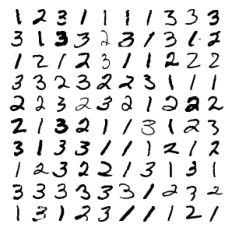

In [4]:
class Dataset:
    """
    Returns the required dataset
    """
    
    def __init__(self, l, size=2):
        self.l = l
        self.size = size
        
    def three_bands(self, n=60):
        X = [(2.5, 2.5), (0, 1.25), (3, 0)]
        Y_L = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
        
        y_lim = (2.5, 3)
        x_lim = (0, 3.5)
        X += get_band(x_lim, y_lim, n)

        y_lim = (1.25, 1.75)
        x_lim = (0, 3.5)
        X += get_band(x_lim, y_lim, n)

        y_lim = (0, 0.5)
        x_lim = (0, 3.5)
        X += get_band(x_lim, y_lim, n)
        

        l = len(Y_L)
        u = len(X) - l
        Y_U = [[0, 0, 0]]*u
        
        Y = Y_L + Y_U
    
        return X, Y, None

    def bridge(self):
        red_x = (-3, 2)
        blue_x = (3, 0)

        Y_L = [[1, 0], [0, 1]]
        X = [red_x, blue_x]


        for i in range(-3, 4):
            for j in range(2, 5):
                if (i, j) != red_x:
                    X.append((i, j))

        X.append((0, 1.5))
        X.append((0, 0.5))

        for i in range(-3, 4):
            for j in range(-2, 1):
                if (i, j) != blue_x:
                    X.append((i, j))

        l = len(Y_L)
        u = len(X) - l
        Y_U = [[0, 0]]*u
        Y = Y_L + Y_U

        return X, Y, None
    
    def mnist(self, compress=True):
        l = self.l
        size = self.size
        orig = get_mnist_raw(size)
#         print(orig[:, 0])
        for val in [1, 2, 3]:
            for i, row in enumerate(orig):
                if row[0] == val:
                    orig[[val-1, i]] = orig[[i, val-1]]
                    break
        
        X_ = orig[:, 1:]
        if not compress:
            X = X_
        else:
            X = []

            for x in X_:
                x = np.reshape(x, (28, 28))
                x = block_reduce(x, block_size=(2, 2), func=np.mean, cval=np.mean(x))
                X.append(x.flatten())
                
            X = np.array(X)
            X_ = X
        y_test = orig[:, 0]
        Y = [[0, 0, 0]] * len(orig)
        for i, row in enumerate(orig):
            if l == 0:
                break
            else:
                Y[i] = one_hot(row[0])
                l -= 1
        
#         print(y_test)
#         print(Y)
        return X, y_test, Y    
        
    def get_data(self, name):
        if name == "bridge":
            return self.bridge()
        elif name == "three_bands":
            return self.three_bands()
        elif name == "mnist":
            return self.mnist()
        else:
            raise NotImplementedError
        
    def view(self, name): # will get updated each time
        if name == "mnist":
            X, y_test, Y = self.mnist(False)
            example_images = X[:100]
            plot_digits(example_images, images_per_row=10)
            return 
        
        elif name == "bridge":
            X, Y, _ = self.bridge()
        elif name == "three_bands":
            X, Y, _ = self.three_bands()
        else:
            raise NotImplementedError
        
        colours = get_classes(Y)
        plt.scatter(*zip(*X), c=colours)      
        
data = Dataset(l=3, size=100)
data.view("mnist")
del data

In [6]:
class Classifier:
    """
    Outputs the classes
    """
    def __init__(self, X, Y, l):
        self.X = X
        self.Y = Y.copy()
        self.l = l
        self.u = len(Y) - l
        self.Y_init = Y.copy()
        
        
    def kNN(self):
        X = np.array(self.X)
        Y = self.Y
        l = self.l
        u = self.u
        for i in range(l, l+u):
            index = -1
            mn = 10**9
            for j in range(l):
                dist = np.linalg.norm(X[i] - X[j])
                if dist < mn:
                    index = j
                    mn = dist
            assert mn < 10**9, "exceeds"
            Y[i] = Y[index].copy()
        return Y
    
    def p1NN(self):
        X = np.array(self.X)
        Y = self.Y
        l = self.l
        u = len(Y) - l
        
        XL = set()
        XU = set()
        
        for i in range(0, l):
            XL.add(i)
        
        for i in range(l, l+u):
            XU.add(i)

        while len(XU):
            lmin = -1
            umin = -1
            mn = 10**9
            for xl in XL:
                for xu in XU:
                    dist = np.linalg.norm(X[xu] - X[xl])
                    if dist < mn:
                        lmin = xl
                        umin = xu
                        mn = dist
#             print(lmin, umin)
            Y[umin] = Y[lmin].copy()
            XU.remove(umin)
            XL.add(umin)      
        return Y
    
    def label_propagation(self, size=10, sigma=10, e=0, max_iter=10000):
        X = self.X
        Y = self.Y
        l = self.l
        u = len(Y) - l
        count = max_iter
        W = get_W(X, sigma)
        assert len(W) == len(Y) and len(W[0]) == len(Y), "invalid"
        T = np.array(get_T(W))
        U = np.full((len(T), len(T)), 1/(len(T)))
        if e is not None:
            T = e*U + (1 - e)*T
        prev_Y = Y.copy()
        Y_L = Y[:l].copy()
        
        while True:
            Y = np.matmul(T, Y)
            for i in range(len(Y)):
                Z = sum(Y[i])
                if Z == 0:
                    raise ValueError
                for j in range(len(Y[i])):
                    Y[i][j] /= Z
            for i in range(l):
                Y[i] = Y_L[i].copy()

            count -= 1
            if count == 0 or (prev_Y == Y).all():
                break
        return Y
    
    def get_pred(self, method, size=2, sigma=None, e=None, max_iter=10000):
        self.Y = self.Y_init.copy()
        
        if method == "kNN":
            return get_classes(self.kNN())
            
        
        elif method == "p1NN":
            return get_classes(self.p1NN())
    
        elif method[:2] == "lp":
            Y = self.label_propagation(size, sigma, e, max_iter)
            if method[2:] == "ml":
                if sigma != None and len(X[1]) >= 196:
                    if e != None:
                        return Y
                    else:
                        return get_hash(Y)
                else:
                    return get_classes(Y)
            elif method[2:] == "lb":
                return label_bidding(Y, size)
            elif method[2:] == "cn":
                Y = class_mass_normalization(Y)
                return get_hash(Y)
            else:
                raise NotImplementedError
        else:
            raise NotImplementedError

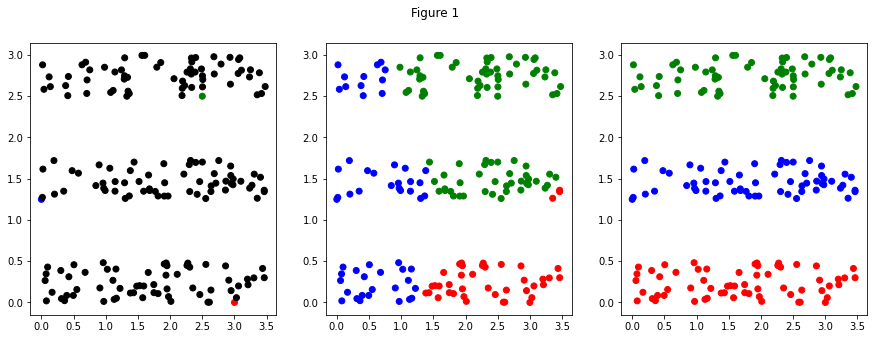

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.suptitle('Figure 1')
fig.set_figheight(5)
fig.set_figwidth(15)

ds = Dataset(l=3)
X, Y, _ = ds.get_data("three_bands")

classifier = Classifier(X, Y, 3)
Y = get_classes(Y)
ax1.scatter(*zip(*X), c=Y)

#kNN
y_knn = classifier.get_pred("kNN")
ax2.scatter(*zip(*X), c=y_knn)
del y_knn, _


# Label Propagation
y_lp = classifier.get_pred("lpml", sigma=0.22)
ax3.scatter(*zip(*X), c=y_lp)
del y_lp

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(3, 3)
fig.tight_layout()
fig.set_figheight(15)
fig.set_figwidth(15)

sigmas = [0.17, 0.4, 0.72, 1.3, 2]
index = 0

ds = Dataset(l=2)
X, Y, _ = ds.get_data("bridge")

classifier = Classifier(X, Y, 2)
Y = get_classes(Y)
axs[0, 0].scatter(*zip(*X), c=Y)

#p1NN
y_p1nn = classifier.get_pred("p1NN")
axs[0, 1].scatter(*zip(*X), c=y_p1nn)

#kNN
y_knn = classifier.get_pred("kNN")
axs[0, 2].scatter(*zip(*X), c=y_knn)


for i in range(1, 3):
    for j in range(3):
        if i == 2 and j == 2:
            break
        
        # Label Propagation
        y_lp = classifier.get_pred("lpml", sigma=sigmas[index])
        axs[i, j].scatter(*zip(*X), c=y_lp)
        axs[i, j].set_title(str(sigmas[index]))
            
        
        index += 1
        

In [ ]:
ds = Dataset(l=3, size=2)
X, Y_test, Y = ds.get_data("mnist")

In [ ]:
classifier = Classifier(X, Y, 3)

y_lp = classifier.get_pred("lpml", sigma=340)
error_rate(y_lp, Y_test)

In [ ]:
classifier = Classifier(X, Y, 3)

y_lp = classifier.get_pred("lplb", sigma=340)
error_rate(y_lp, Y_test)

In [ ]:
classifier = Classifier(X, Y, 3)

y_lp = classifier.get_pred("lpcn", sigma=340)
error_rate(y_lp, Y_test)

In [ ]:
cols = ['method', 3, 6, 9, 12, 15, 20, 25, 30]
table1 = pd.DataFrame(columns=cols)
iterations = 5

for method in ["p1NN", "kNN", "lpml", "lpcn", "lplb"]:
    errors = []
    for l in cols[1:]:
        cur = 0
        for _ in range(iterations):
            ds = Dataset(l=l, size=60)
            X, Y_test, Y = ds.get_data("mnist")
            classifier = Classifier(X, Y, l)
            y = classifier.get_pred(method, sigma=340)
            y = format_pred(y)
    #         print(y_p1nn)
    #         print(Y_test)
    #         plot_digits(X, size=14)
            if method not in ["lpcn", "lplb"]:
                check_match(Y, y, Y_test)
            cur += error_rate(y, Y_test)
        errors.append(cur/iterations)   
    table1 = pd.concat([pd.DataFrame([[method] + errors], columns=table1.columns), table1], ignore_index=True)

<ipython-input-3-3801add5c845>:124: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(y_pred != y_test)/len(y_test)
<ipython-input-3-3801add5c845>:124: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(y_pred != y_test)/len(y_test)
<ipython-input-3-3801add5c845>:124: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(y_pred != y_test)/len(y_test)
<ipython-input-3-3801add5c845>:124: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(y_pred != y_test)/len(y_test)


# Error Rate Table

In [ ]:
table1.iloc[::-1].head(4)

In [ ]:
from mpl_toolkits import mplot3d

%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')

r = 2

X = []
X_ = []
for i in range(25):
    angle = 2*math.pi*i/25
    x = r*math.cos(angle)
    y = r*math.sin(angle)
    z = i
    X.append((x, y, z))
    X_.append((y, x, z))

red_x = (2, 0, 0)
blue_x = (0, 2, 25) 


X = [red_x, blue_x] + X + X_
Y_L = [[1, 0], [0, 1]]
l = len(Y_L)
u = len(X) - l
Y = Y_L + [[0, 0]]*u

ax.scatter3D(*zip(*X))

In [16]:
from scipy import sparse
from scipy.sparse.linalg.eigen.arpack import eigsh
import pandas as pd

In [17]:
def normalise(mat):
    """mat gets row-normalized"""
    row_sum = np.array(mat.sum(1))
    reciprocal = np.reciprocal(row_sum).flatten()
    reciprocal[np.isinf(reciprocal)] = 0
    reciprocal_mat = sparse.diags(reciprocal)
    return reciprocal_mat.dot(mat)


def get_onehot(labels):
    s = pd.Series(labels)
    df = pd.get_dummies(s)
    return df.to_numpy()

def load_data(dataset="cora"):
    X_data = np.genfromtxt("pygcn\cora\cora.content", dtype=np.string_)
    graph_data = np.genfromtxt("pygcn\cora\cora.cites", dtype=np.int32)

    features = normalise(sparse.csr_matrix(X_data[:, 1:-1], dtype=np.float32))
    labels = get_onehot(X_data[:, -1])
    indices = np.array(X_data[:, 0], dtype=np.int32)
    indices_dict = {paper_id: i for i, paper_id in enumerate(indices)}
    E = np.array(
      list(map(indices_dict.get, graph_data.flatten())), dtype=np.int32
    ).reshape(graph_data.shape) 

    A = sparse.coo_matrix(
      (np.ones(E.shape[0]), (E[:, 0], E[:, 1])),
      (labels.shape[0], labels.shape[0]),
      np.float32
    )


    train_indices = range(140)
    val_indices = range(200, 500)
    test_indices = range(500,1500)

    features = np.array(features.todense())
    labels = np.nonzero(labels)[1]

    
    features 

    for data in [A, features, labels, train_indices, val_indices, test_indices]:
        yield data

In [18]:
A, X, labels, train_indices, val_indices, test_indices = load_data()


In [28]:
def get_onehot(labels):
    s = pd.Series(labels)
    df = pd.get_dummies(s)
    return df.to_numpy()

one_hot = get_onehot(range(7))


In [39]:
classifier = Classifier(X[:140], [one_hot[labels[i]] for i in range(140)], 10)
y_lp = classifier.get_pred("lpml", sigma=0.22)


In [41]:
100 - error_rate(y_lp, labels.tolist())

99.9996307237814